# Coursework: Fashion MNIST MLP
**NOTE:** Please save my_utils1.py in folder 'content/gdrive/MyDrive/Colab Notebooks'

## The Task
The aim of this project is to use a predefined neural architecture to classify images from the Zolando fashion-mnist dataset with the highest accuracy. Modifications will be made to the network architecture and training pipeline to improve the model accuracy as far as possible.

### Subtasks
1. Read dataset and create dataloaders
1. Create the model
1. Create the loss and optimizer
1. Write the training script
 1. Curves for training loss, training accuracy and validation (test) accuracy
 1. Hyperparameter details

1. Obtain final model training loss, training accuracy and test accuracy

### Final Training Pipeline
* loss: cross entropy loss
* initialisation of weights: Xavier normal
* optimizer: Adam
* training data augmentation: random resized crops (in my_utils1.py)
* learning rate scheduler: exponential

### Final Network Architecture
Additions to original model in **bold**
***
Stem:
- Create N non-overlapping patches from 28x28 image from fashion-mnist
- Vectorise each patch
- Transform each patch vector into a feature vector using the same transformation
 - **Design decision:** use a single linear layer for this transformation
- Store as tensor
***
Backbone:
- N blocks consisting of:
 - **Layer Normalisation**
 - Transpose input
 - Multi-layer perceptron 1
   - Linear layer
   - Non-linear activation function (ReLU)
   - Linear layer
 - Transpose output of MLP 1
 - **Layer Normalisation**
 - Multi-layer perceptron 2
   - Linear layer
   - Non-linear activation function (ReLU)
   - Linear Layer

- **Dropout layer**
***
Classifier:
- Compute mean feature across patches
- **Design decision:** single linear layer to output of size 10
- **Design decision:** softmax classifier (implemented through CrossEntropyLoss)


## Set up Google Drive and Prerequisites

In [ ]:
# Setting up google drive
# This code is taken from the labs
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive


In [ ]:
# Import libraries
# This code is taken from the labs
import my_utils1 as mu   # my_utils is editted to include training data augmentation
import torch
from torch import nn
import torch.optim.lr_scheduler as sc

## 1. Read Dataset and Create Data Loaders

In [ ]:
# This code is taken from the labs
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 2. Create the Model

In [ ]:
# the VGG block code from labs was used as a starting point for the
# backbone block class below, but was changed sufficiently that it no longer
# resembles the original code
class backbone_block(nn.Module):
  def __init__(self, input_features, hidden_features, output_features, num_patches):
    super(backbone_block, self).__init__()
    self.add_module('linear1', nn.Linear(num_patches, num_patches))
    self.add_module('linear2', nn.Linear(num_patches, num_patches))
    self.add_module('linear3', nn.Linear(input_features, hidden_features))
    self.add_module('linear4', nn.Linear(hidden_features, output_features))
    self.add_module('relu', nn.ReLU())
    self.add_module('layernorm1', nn.LayerNorm(input_features))
    self.add_module('layernorm2', nn.LayerNorm(input_features))

  def forward(self, x):
    # layer normalisation was inspired by Tolstikhin et al.’s (2021) MLP mixer
    # architecture - for reference see accompanying documentation
    x = self._modules['layernorm1'](x)   # normalisation over features

    # MLP 1 - patch mixing
    x = torch.transpose(x, 1, 2)   # gives tensor of size (n_batches, n_features, n_patches)
    x = self._modules['linear1'](x)
    x = self._modules['relu'](x)
    x = self._modules['linear2'](x)
    x = torch.transpose(x, 1, 2)   # gives tensor of size (n_batches, n_patches, n_features)

    x = self._modules['layernorm2'](x)   # normalisation over features

    # MLP 2 - feature mixing
    x = self._modules['linear3'](x)
    x = self._modules['relu'](x)
    x = self._modules['linear4'](x)
    out = x
    return out

In [ ]:
class Net(nn.Module):
  def __init__(self, num_patches, patch_size, num_features, num_outputs, block_arch):
    super(Net, self).__init__()
    self.num_patches = num_patches
    self.patch_size = patch_size
    self.num_features = num_features
    self.num_outputs = num_outputs
    self.block_arch = block_arch

    # Stem
    self.uf = nn.Unfold(patch_size, stride=patch_size)   # generate patches and vectorise
    self.get_features = nn.Linear(patch_size**2, num_features)   # generate features for each patch using linear layer

    # Backbone
    # This code is adapted from the VGG labs
    input_features = num_features
    for i, (hidden_features, output_features) in enumerate(block_arch):
      self.add_module('block{0}'.format(i), 
                      backbone_block(input_features, hidden_features, 
                                    output_features, num_patches))
      input_features = output_features

    self.dropout = nn.Dropout(0.25)

    # Classifier
    self.mean = nn.AvgPool2d((num_patches, 1))
    self.fl = nn.Flatten()
    self.lin_classify = nn.Linear(block_arch[len(block_arch)-1][1], output_features)

  def forward(self, x):
    # Stem
    x = self.uf(x)   # gives tensor of size (n_batches, patch_size**2, n_patches)
    x = torch.transpose(x, 1, 2)   # gives tensor of size (n_batches, n_patches, patch_size**2)
    x = self.get_features(x)   # gives tensor of size (n_batches, n_patches, n_features)

    # Backbone
    for i in range(len(self.block_arch)):
      x = self._modules['block{0}'.format(i)](x)   # generate N backbone blocks as specified by block_arch

    x = self.dropout(x)

    # classifier
    x = self.mean(x)   # take average of features across all patches
    x = self.fl(x)   # remove patch dimension
    x = self.lin_classify(x)   # linear (fully-connected) classifier - softmax implemented in loss function
    return x

### Initialise model

In [ ]:
# This code is adapted from the labs
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_normal_(m.weight)          

num_patches = 4
patch_size = 14   # 14x14
num_features = 512   # generated in stem
num_outputs = 10   # 10 classes of clothes in fashion-mnist
block_arch = ((512, 256),(128, 64))   # for each block: (MLP2_hidden_units, MLP2_output_units)
model = Net(num_patches, patch_size, num_features, num_outputs, block_arch)

model.apply(init_weights);
print(model)

Net(
  (uf): Unfold(kernel_size=14, dilation=1, padding=0, stride=14)
  (get_features): Linear(in_features=196, out_features=512, bias=True)
  (block0): backbone_block(
    (linear1): Linear(in_features=4, out_features=4, bias=True)
    (linear2): Linear(in_features=4, out_features=4, bias=True)
    (linear3): Linear(in_features=512, out_features=512, bias=True)
    (linear4): Linear(in_features=512, out_features=256, bias=True)
    (relu): ReLU()
    (layernorm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layernorm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (block1): backbone_block(
    (linear1): Linear(in_features=4, out_features=4, bias=True)
    (linear2): Linear(in_features=4, out_features=4, bias=True)
    (linear3): Linear(in_features=256, out_features=128, bias=True)
    (linear4): Linear(in_features=128, out_features=64, bias=True)
    (relu): ReLU()
    (layernorm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (layernorm2): 

## 3. Loss and Optimization Algorithm

In [ ]:
# This code is taken from the labs - I added an exponential learning rate scheduler
loss = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = sc.ExponentialLR(optimizer, gamma=0.9)

## 4. Training Script

In [ ]:
num_epochs = 20

In [ ]:
# This code is taken from the labs - I added an exponential learning rate scheduler
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, scheduler, device):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()

    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
        scheduler.step()   # added scheduler

    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

## 5. Train and Obtain Final Metrics

loss 0.179, train acc 0.933, test acc 0.900
2175.7 examples/sec on cpu


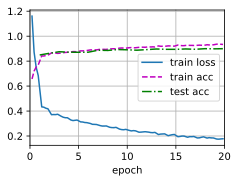

In [ ]:
# code taken from labs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
trainf(model, train_iter, test_iter, loss, num_epochs, optimizer, scheduler, device)